In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import glob


### ics.uci.edu-755

- Line 20930 in the dataset was modified (timestamp was in datetime format)

It seems like this dataset has only "walking" data (over 98%). Most likely unusable for our purposes

In [10]:
df = pd.read_csv("../data/ics.uci.edu-755/dataset.csv")

In [11]:
# Count distribution
activity_counts = df['Activity'].value_counts().sort_index()

# Display counts and percentages
for activity, count in activity_counts.items():
    label = "Standing (0)" if activity == 0 else "Walking (1)"
    percentage = count / len(df) * 100
    print(f"{label}: {count} samples ({percentage:.2f}%)")


Standing (0): 571 samples (1.78%)
Walking (1): 31420 samples (98.22%)


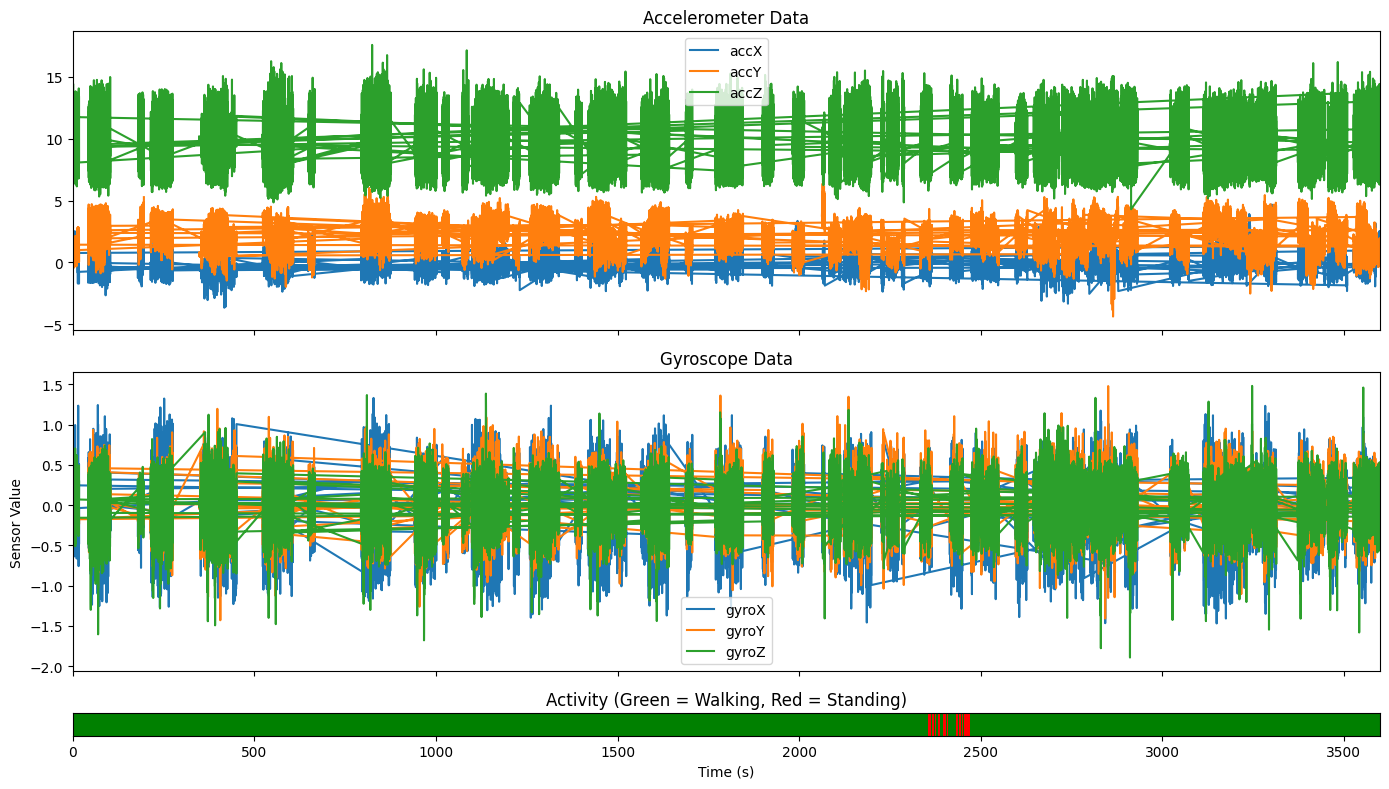

In [15]:


# Parse MM:SS.s to seconds
def parse_time(t):
    minutes, seconds = t.split(":")
    return int(minutes) * 60 + float(seconds)

df['time_sec'] = df['timestamp'].apply(parse_time)

# Create a numeric array for activity (0 or 1)
activity_array = df['Activity'].values.reshape(1, -1)

# Custom color map: 0 = red, 1 = green
cmap = mcolors.ListedColormap(['red', 'green'])

# Plot
fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True,
                        gridspec_kw={"height_ratios": [4, 4, 0.3]})

# Accelerometer
axs[0].set_title("Accelerometer Data")
for axis in ['accX', 'accY', 'accZ']:
    axs[0].plot(df['time_sec'], df[axis], label=axis)
axs[0].legend()

# Gyroscope
axs[1].set_title("Gyroscope Data")
for axis in ['gyroX', 'gyroY', 'gyroZ']:
    axs[1].plot(df['time_sec'], df[axis], label=axis)
axs[1].legend()

# Activity strip
axs[2].imshow(activity_array, aspect='auto', cmap=cmap,
              extent=[df['time_sec'].min(), df['time_sec'].max(), 0, 1])
axs[2].set_yticks([])
axs[2].set_title("Activity (Green = Walking, Red = Standing)")

# Labels
axs[1].set_ylabel("Sensor Value")
axs[2].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

### Kaggle-vmalyi

- This dataset labels Walking and Running. Could still be useful visually
- First code snippet resaves the file, merging the date + time into timestamp and removing the user column

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import glob


In [17]:

# Load original dataset
df = pd.read_csv("../data/kaggle-vmalyi/dataset.csv")

# Replace last ':' in time with '.' to match standard datetime format
df['time'] = df['time'].str.replace(r':(?=\d{6,9}$)', '.', regex=True)

# Combine date and time into a single timestamp
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')

# Drop original date, time, and username columns
df_cleaned = df.drop(columns=['date', 'time', 'username'])

# Optional: move timestamp to front
cols = ['timestamp'] + [col for col in df_cleaned.columns if col != 'timestamp']
df_cleaned = df_cleaned[cols]

# Save to a new CSV
df_cleaned.to_csv("../data/kaggle-vmalyi/clean_dataset.csv", index=False)

activity_counts = df['activity'].value_counts().sort_index()

# Print out the results
for activity, count in activity_counts.items():
    label = "Walking (0)" if activity == 0 else "Running (1)"
    percentage = count / len(df) * 100
    print(f"{label}: {count} samples ({percentage:.2f}%)")

print("Cleaned dataset saved as 'clean_dataset.csv'")


Walking (0): 44223 samples (49.92%)
Running (1): 44365 samples (50.08%)
Cleaned dataset saved as 'clean_dataset.csv'


This data must be split into segments, because it holds separate recording sessions

In [19]:
# Load cleaned dataset (timestamp must already be parsed as datetime)
df = pd.read_csv("../data/kaggle-vmalyi/clean_dataset.csv", parse_dates=['timestamp'])

# Sort by timestamp just in case
df = df.sort_values('timestamp')

# Compute time differences between rows (in seconds)
df['delta'] = df['timestamp'].diff().dt.total_seconds()

# Define a threshold (e.g., anything above 1 sec is a new session)
threshold = 60.0

# Identify segment boundaries
segment_id = (df['delta'] > threshold).cumsum()
df['segment'] = segment_id

# Save each segment into a separate file
for seg in df['segment'].unique():
    segment_df = df[df['segment'] == seg].drop(columns=['delta', 'segment'])
    segment_df.to_csv(f"../data/kaggle-vmalyi/segments/segment_{seg}.csv", index=False)

print(f"Saved {df['segment'].nunique()} segments.")

Saved 41 segments.


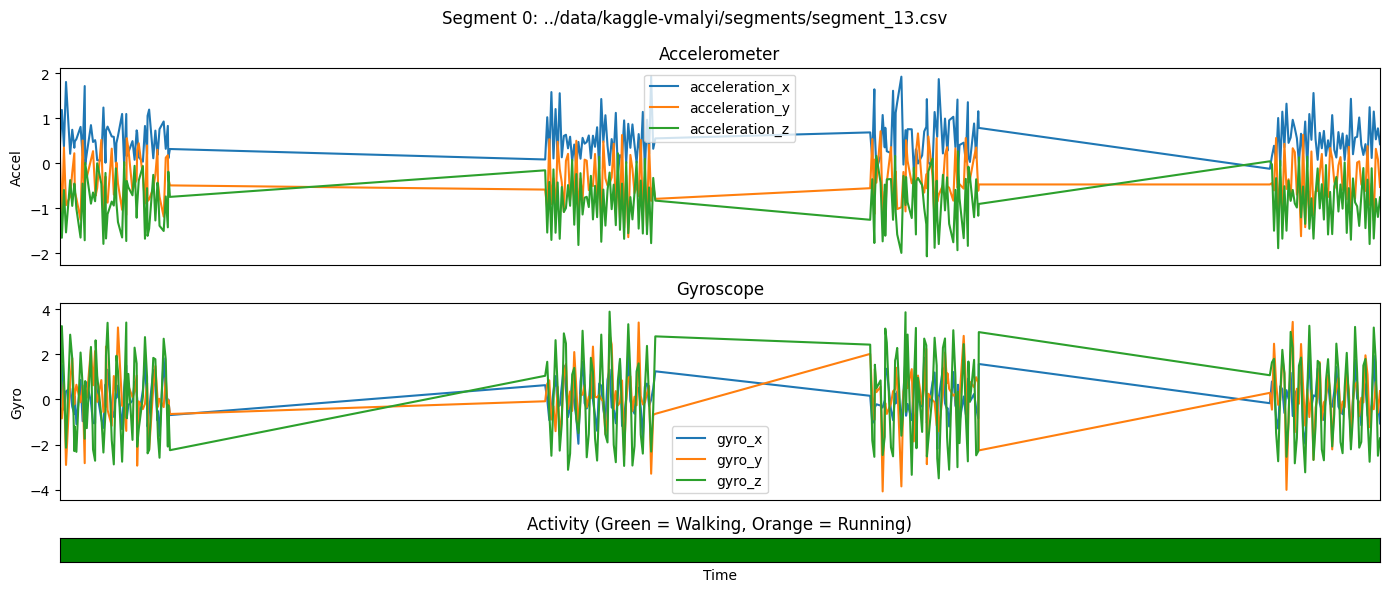

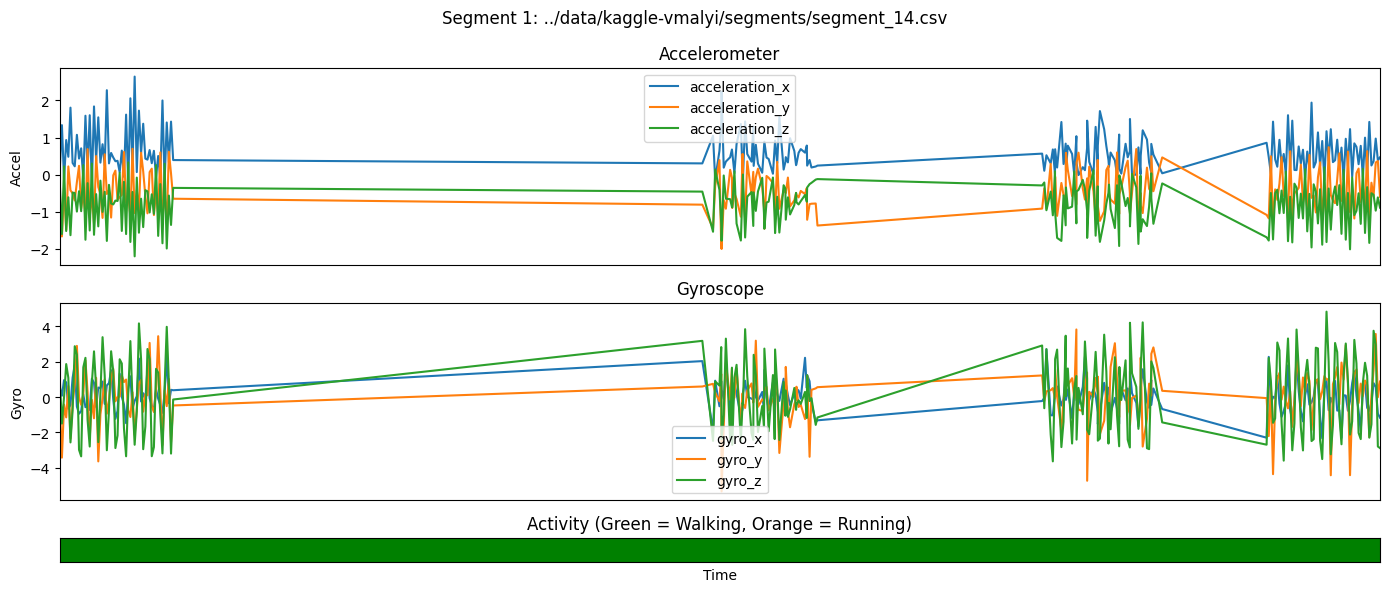

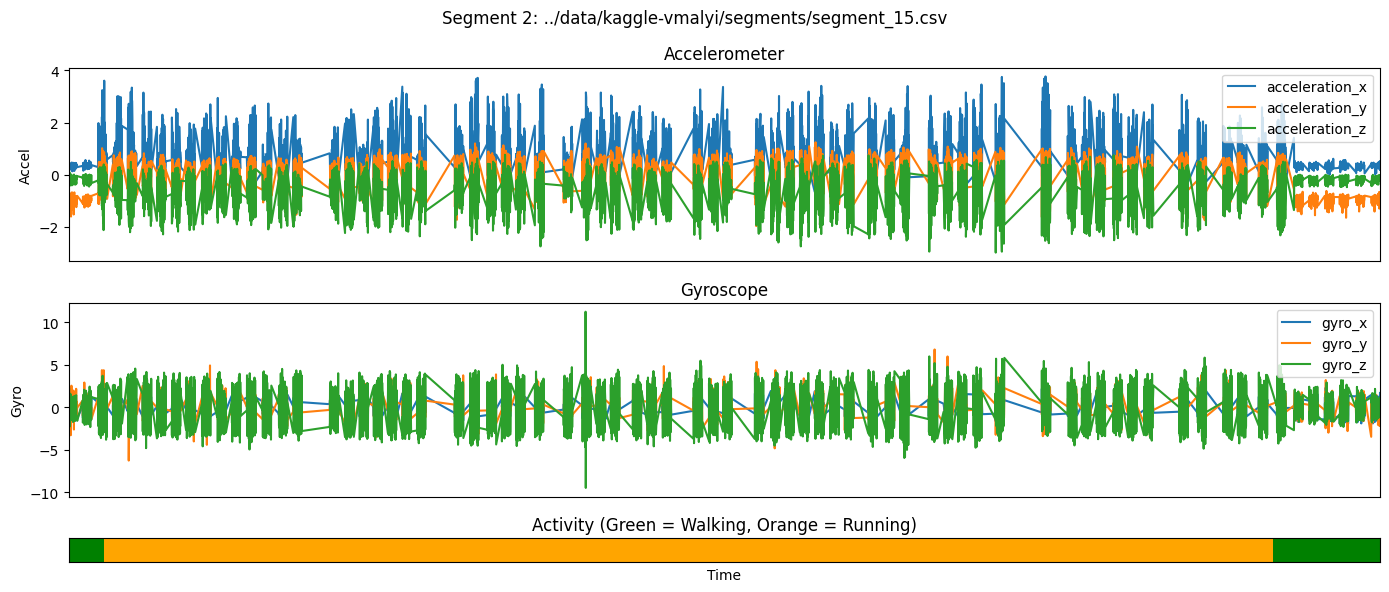

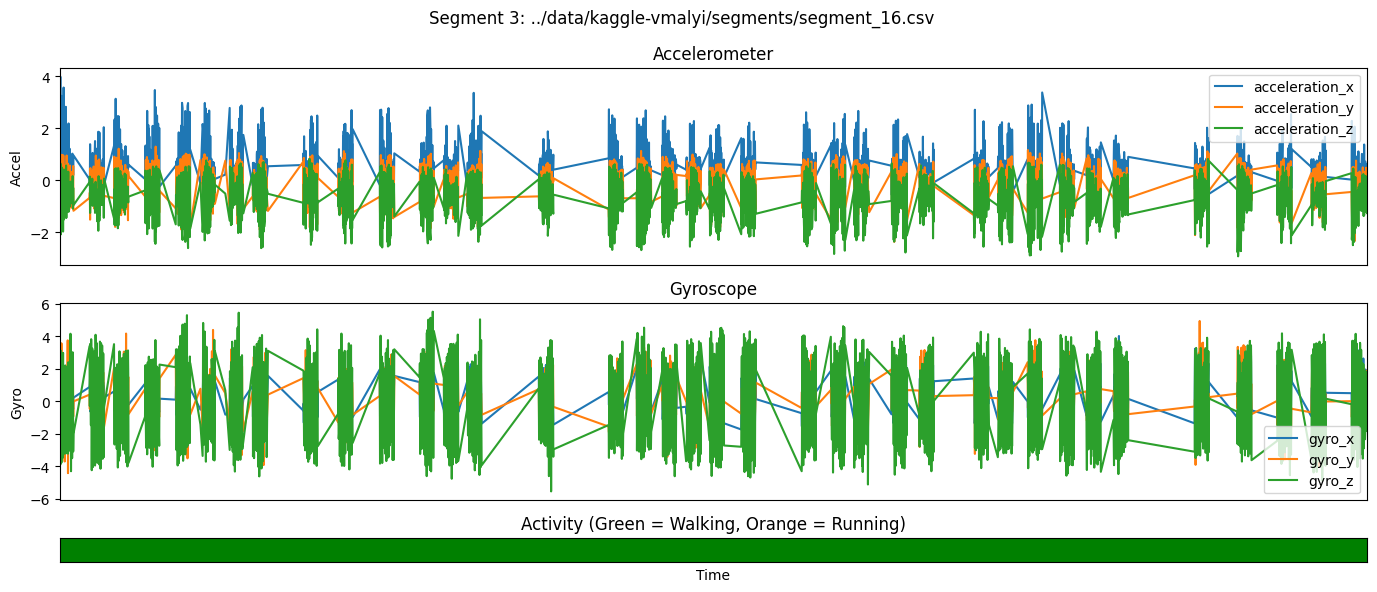

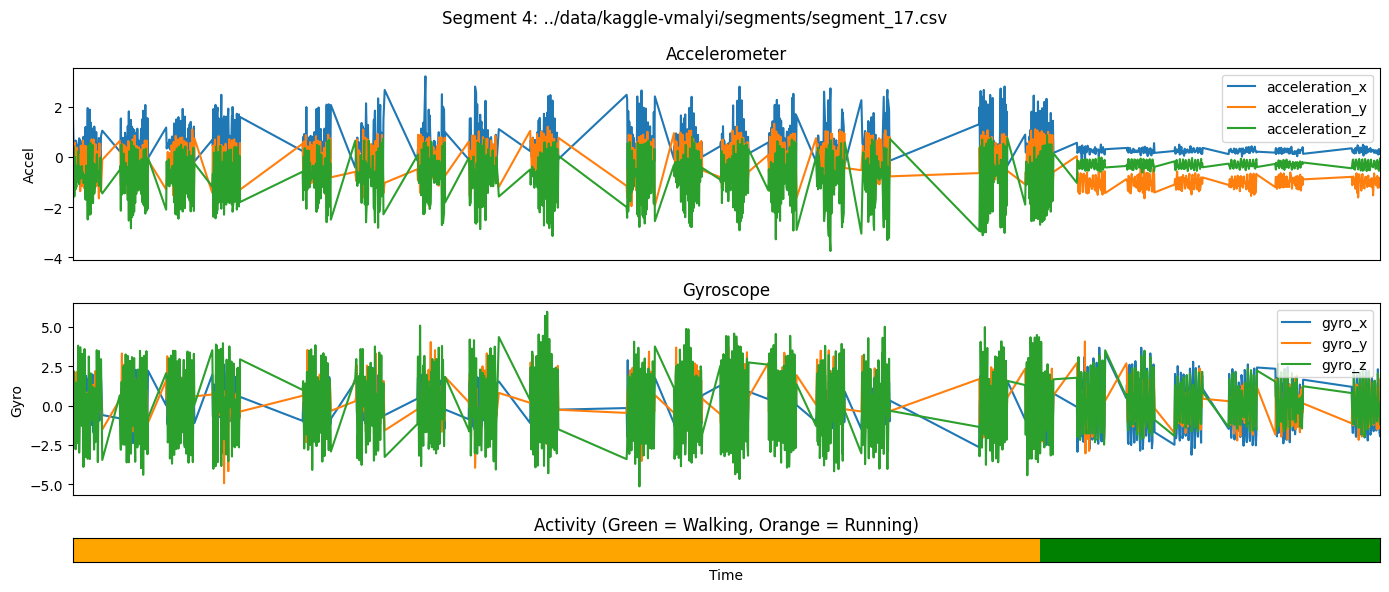

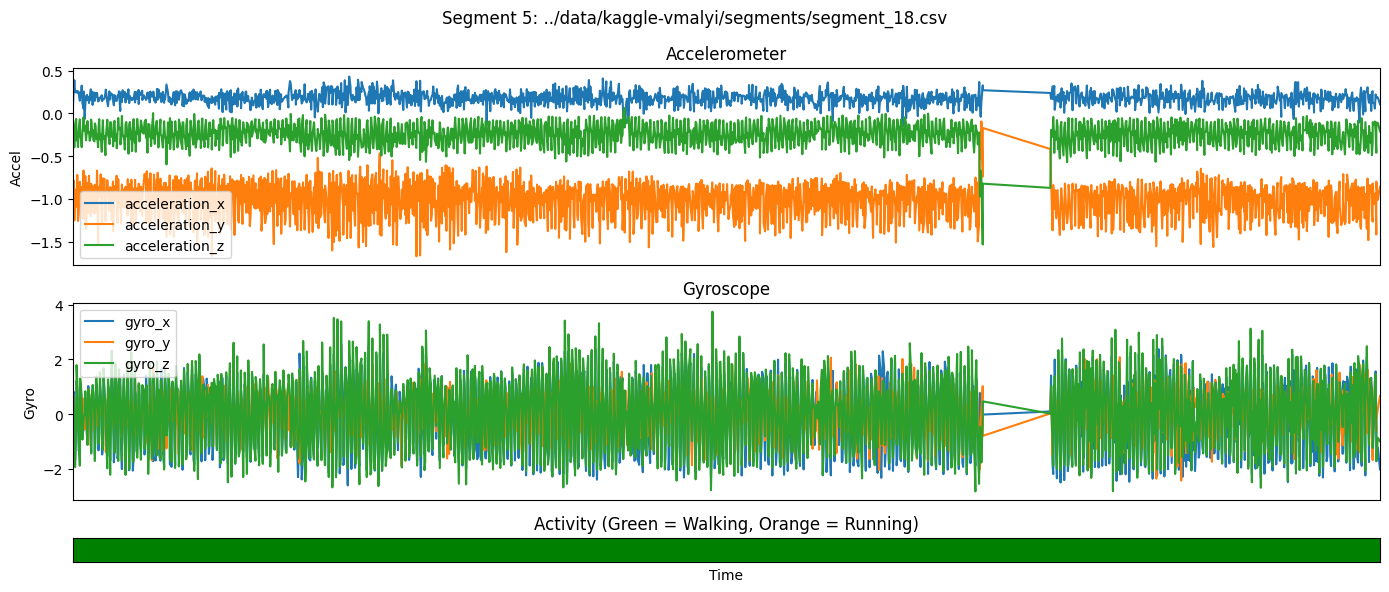

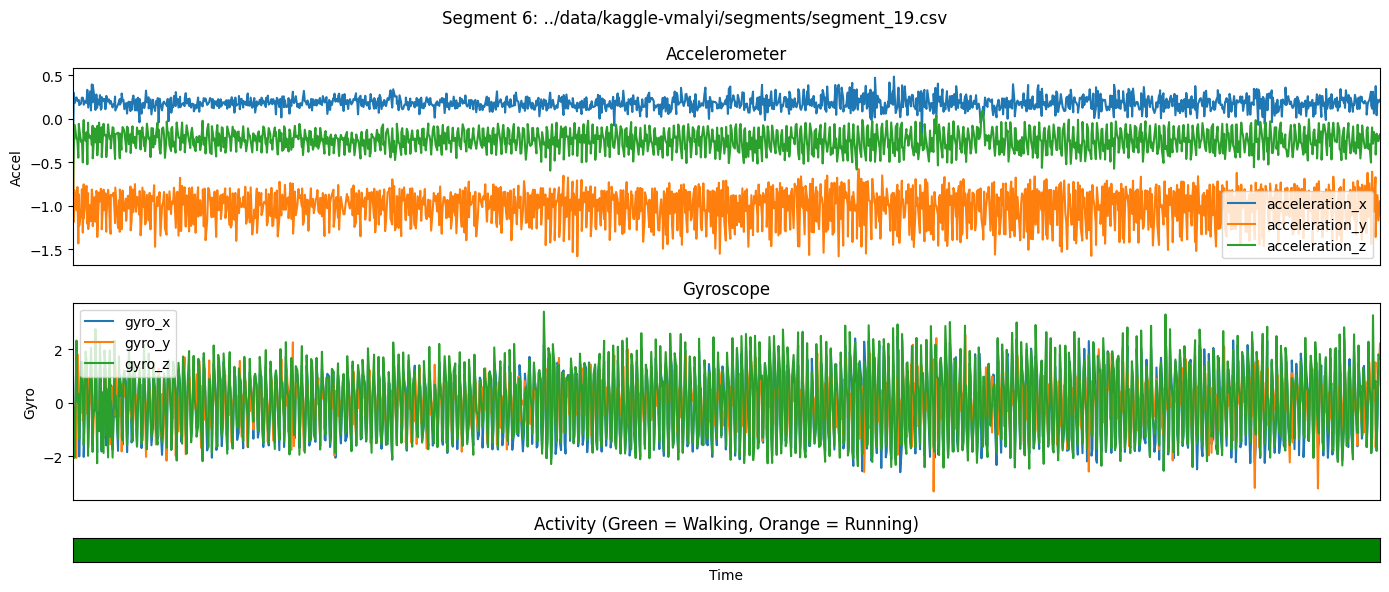

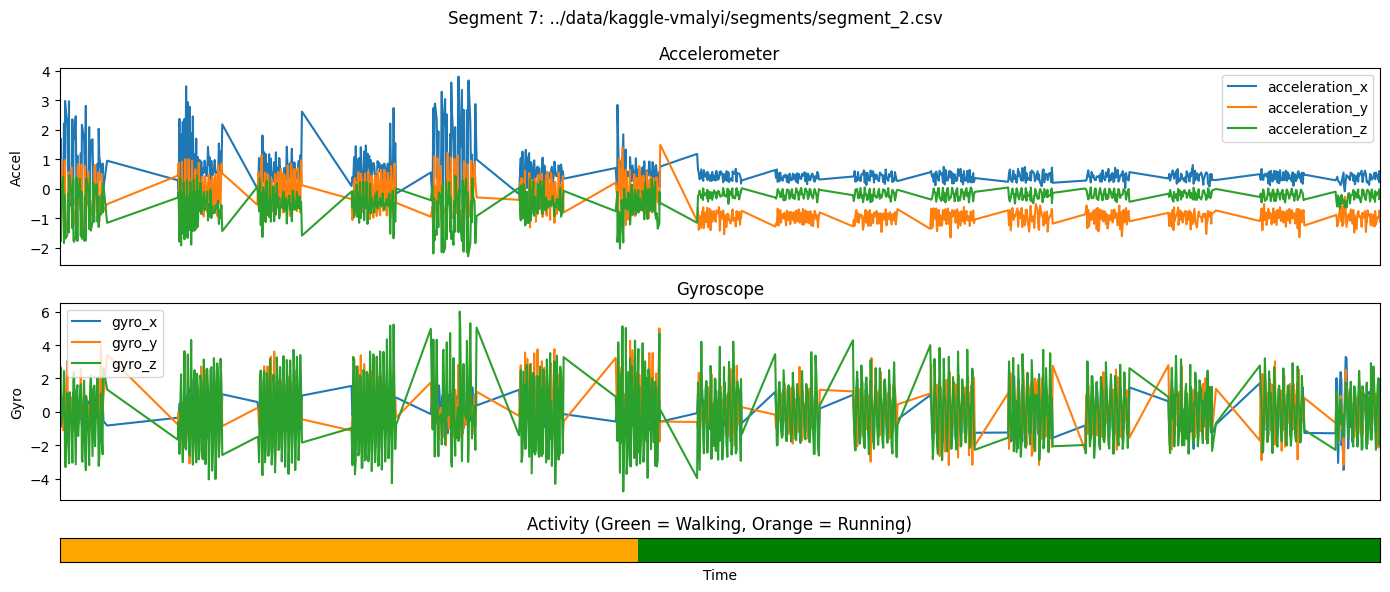

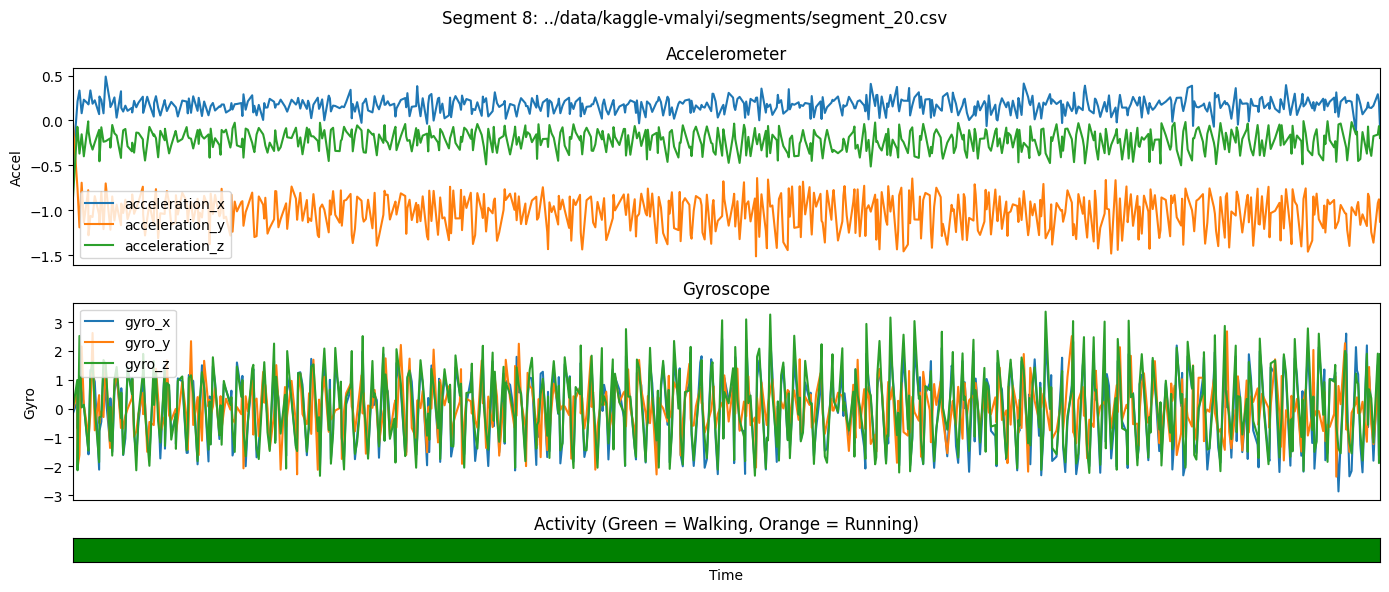

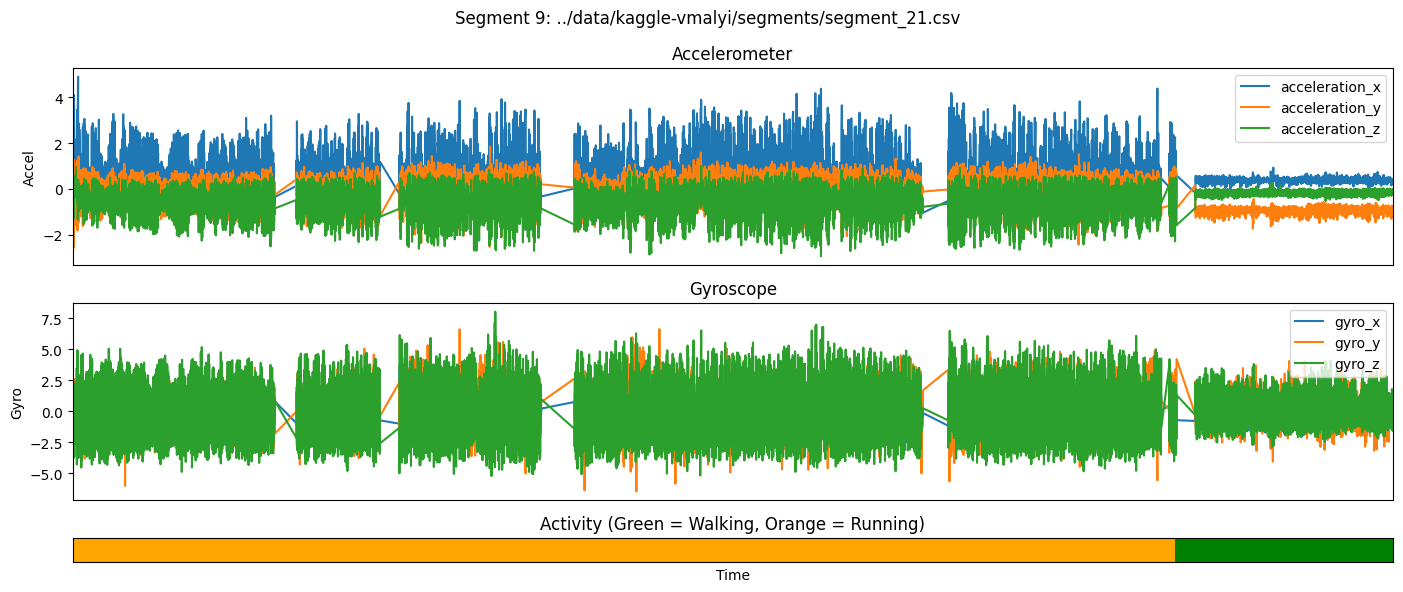

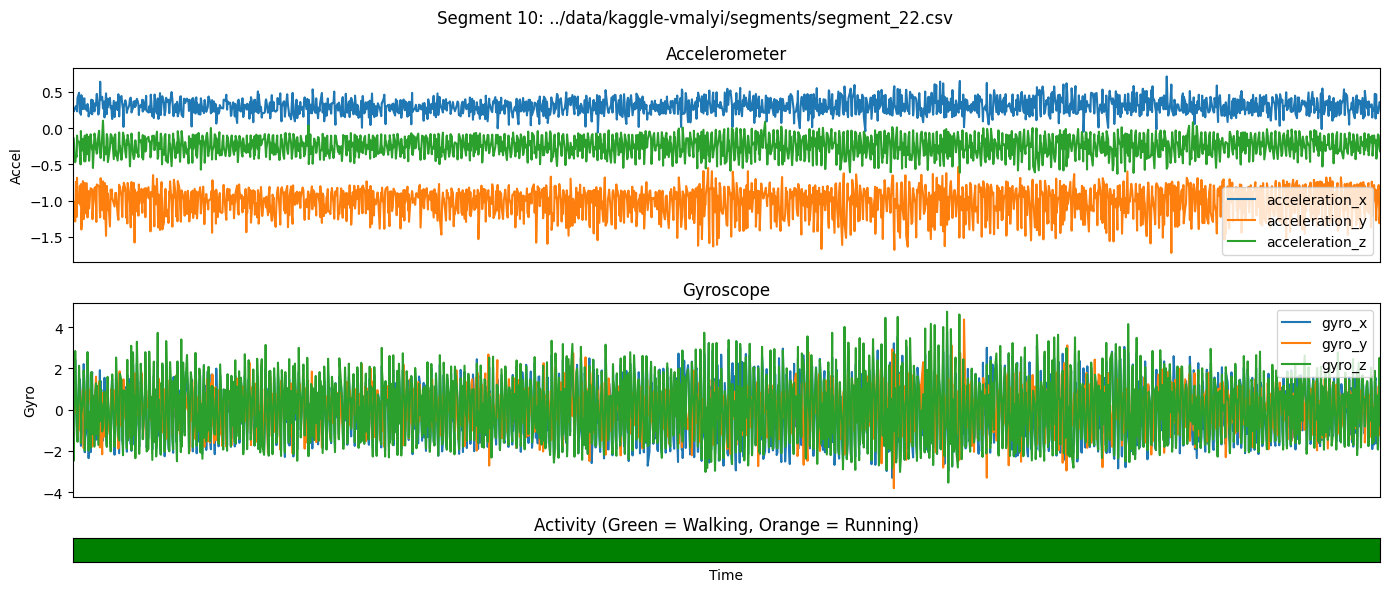

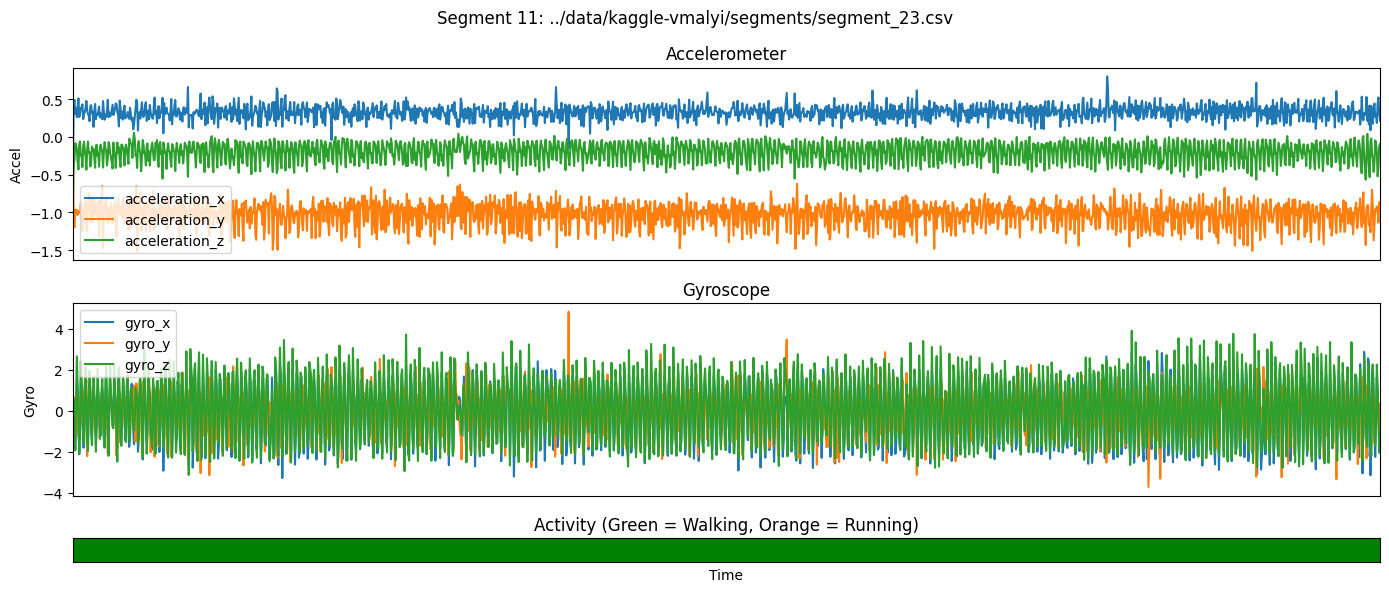

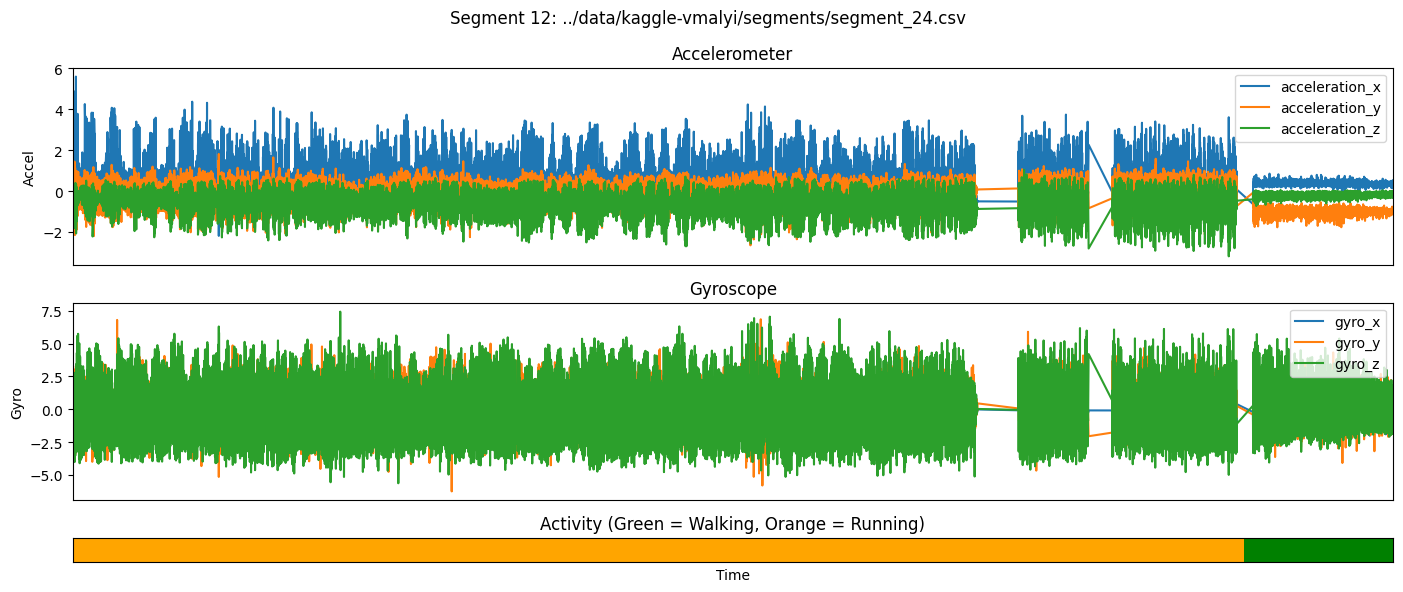

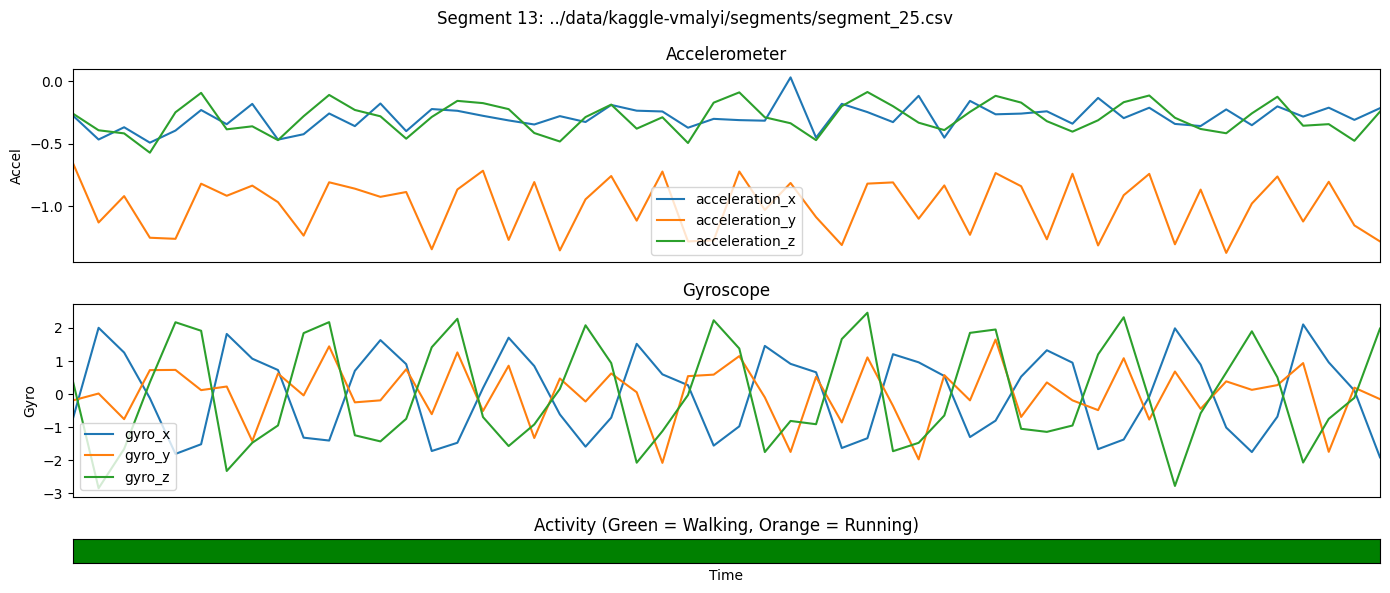

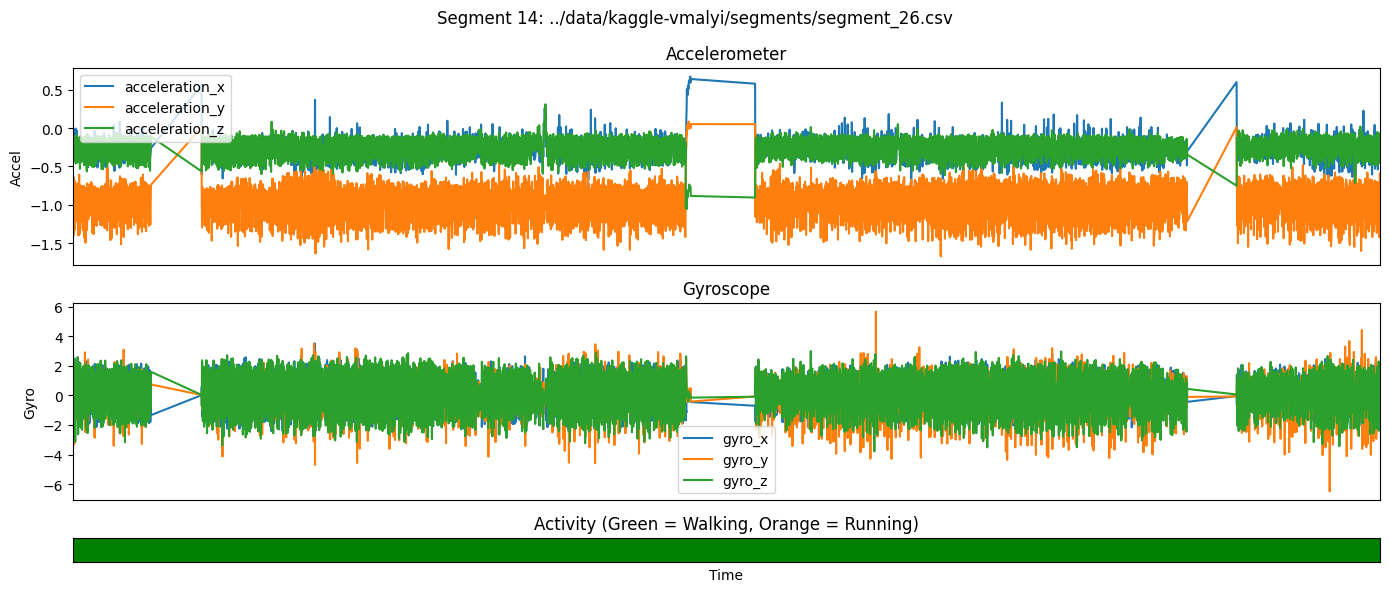

In [22]:

file_start = 5
nr_of_files = 15  # how many segments to show

segment_paths = sorted(glob.glob("../data/kaggle-vmalyi/segments/segment_*.csv"))
selected_files = segment_paths[file_start:file_start + nr_of_files]

for i, file in enumerate(selected_files):
    df = pd.read_csv(file, parse_dates=['timestamp'])

    df['time_sec'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()

    # Set up figure
    fig, axs = plt.subplots(3, 1, figsize=(14, 6), sharex=True, 
                            gridspec_kw={"height_ratios": [4, 4, 0.5]})
    fig.suptitle(f"Segment {i}: {file}")

    # Accelerometer
    axs[0].set_title("Accelerometer")
    for axis in ['acceleration_x', 'acceleration_y', 'acceleration_z']:
        axs[0].plot(df['time_sec'], df[axis], label=axis)
    axs[0].legend()

    # Gyroscope
    axs[1].set_title("Gyroscope")
    for axis in ['gyro_x', 'gyro_y', 'gyro_z']:
        axs[1].plot(df['time_sec'], df[axis], label=axis)
    axs[1].legend()

    # Activity bar (green = walking [0], orange = running [1])
    activity_array = df['activity'].values.reshape(1, -1)
    cmap = mcolors.ListedColormap(['green', 'orange'])
    axs[2].imshow(activity_array, aspect='auto', cmap=cmap,
                extent=[df['time_sec'].min(), df['time_sec'].max(), 0, 1])
    axs[2].set_yticks([])
    axs[2].set_title("Activity (Green = Walking, Orange = Running)")

    # Sync x-axis to timestamps
    axs[2].set_xticks([])
    axs[1].set_ylabel("Gyro")
    axs[0].set_ylabel("Accel")
    axs[2].set_xlabel("Time")

    plt.tight_layout()
    plt.show()

### Mendleey-Cristiana-Gabriel

- Contains walking info (acc, gyr, mag) for over 200 patients, alongside their user data

In [24]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

In [26]:
def load_user_session(folder_path, how='outer'):
    """
    Loads and aligns accelerometer, gyroscope, and magnetometer data.
    Returns:
        - merged_df: DataFrame with aligned sensor data
        - metadata: user info dict
    """
    def load_sensor_file(filepath):
        df = pd.read_csv(filepath, sep="\t")

        df.columns = df.columns.str.strip()
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

        df = df.dropna(subset=['Timestamp'])
        df = df.set_index('Timestamp')
        df = df.resample('20ms').mean().interpolate()
        return df

    sensors = {}
    for sensor in ['accelerometer', 'gyroscope', 'magnetometer']:
        file_path = os.path.join(folder_path, f"{sensor}.txt")
        if os.path.exists(file_path):
            sensors[sensor] = load_sensor_file(file_path)
            # Rename columns to avoid collision (X_acc, Y_acc, etc.)
            sensors[sensor].columns = [f"{col}_{sensor[:4]}" for col in sensors[sensor].columns]

    # Merge all available sensors
    merged_df = None
    for df in sensors.values():
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how=how)

    # Load metadata
    metadata_path = os.path.join(folder_path, "user_data.json")
    metadata = {}
    if os.path.exists(metadata_path):
        with open(metadata_path) as f:
            metadata = json.load(f)

    return merged_df, metadata


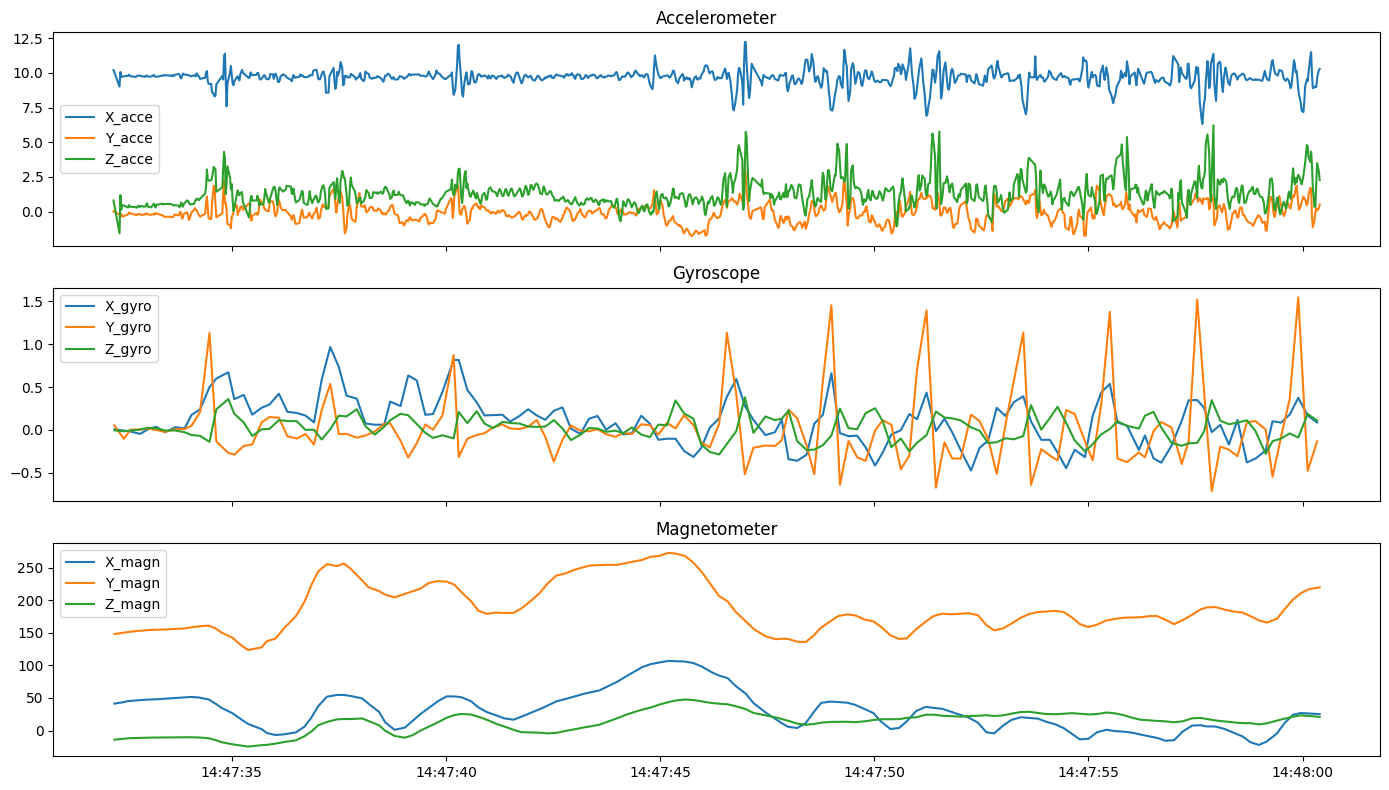

In [27]:
file_to_load = 50

df, meta = load_user_session(f'../data/mendeley-Cristiana-Gabriel/datasets/{file_to_load}')

fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)


# Accelerometer
axs[0].set_title("Accelerometer")
for col in ['X_acce', 'Y_acce', 'Z_acce']:
    if col in df.columns:
        axs[0].plot(df.index, df[col], label=col)
axs[0].legend()

# Gyroscope
axs[1].set_title("Gyroscope")
for col in ['X_gyro', 'Y_gyro', 'Z_gyro']:
    if col in df.columns:
        axs[1].plot(df.index, df[col], label=col)
axs[1].legend()

# Magnetometer
axs[2].set_title("Magnetometer")
for col in ['X_magn', 'Y_magn', 'Z_magn']:
    if col in df.columns:
        axs[2].plot(df.index, df[col], label=col)
axs[2].legend()

plt.tight_layout()
plt.show()



### Kaggle-malekzadeh

In [28]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [29]:
def load_kaggle_malekzadeh_dataset(base_path):
    dataset = []

    # Loop through each activity folder
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        # Extract label (e.g., jog, wlk, sit, std)
        label = folder.split("_")[0]

        # Loop through each CSV file
        for csv_file in glob(os.path.join(folder_path, "sub_*.csv")):
            df = pd.read_csv(csv_file)
            df.columns = df.columns.str.strip()  # remove leading/trailing spaces
            dataset.append((df, label, csv_file))

    return dataset


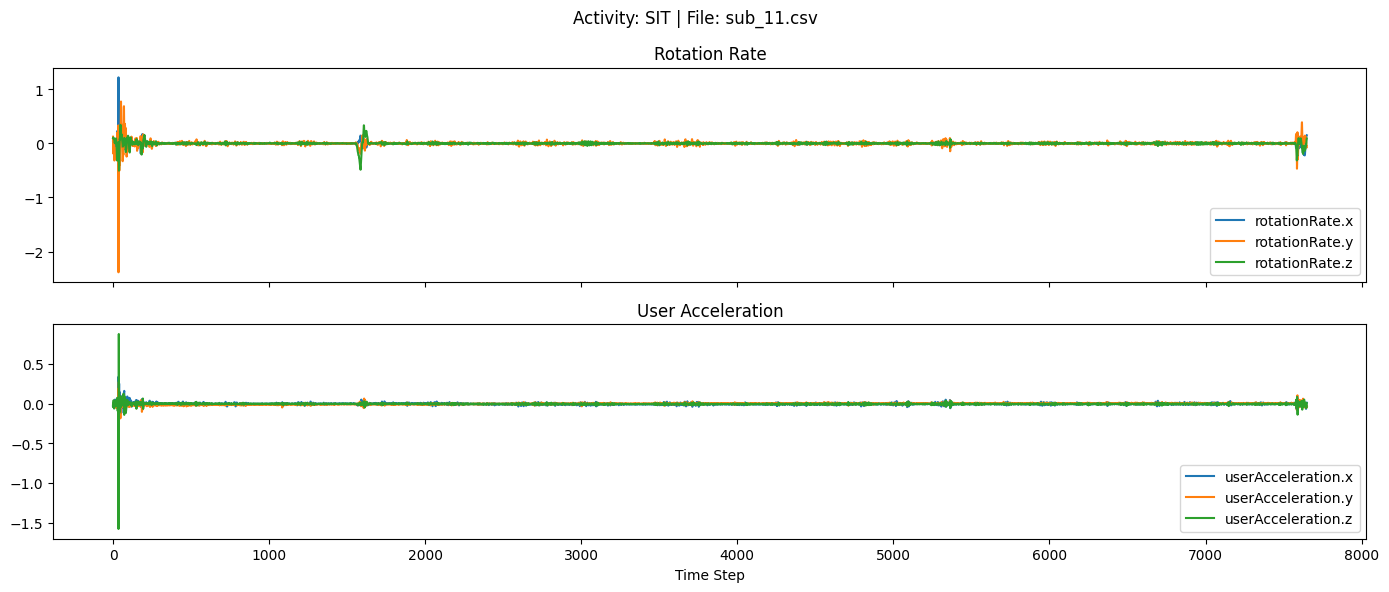

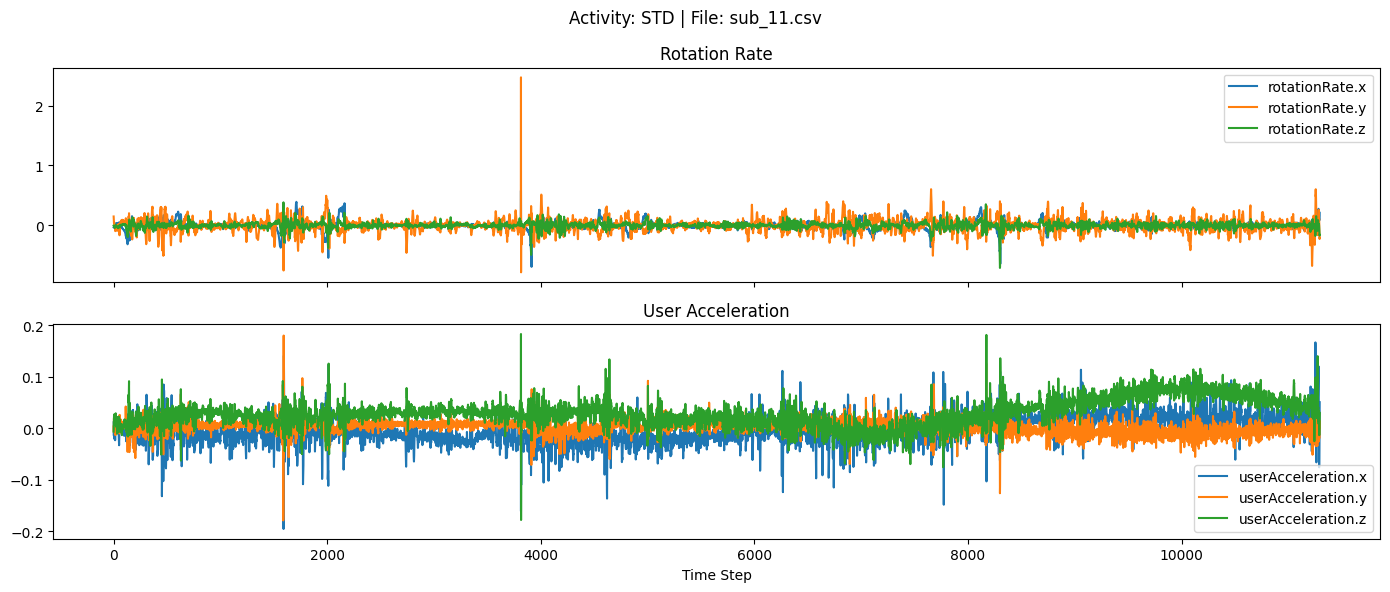

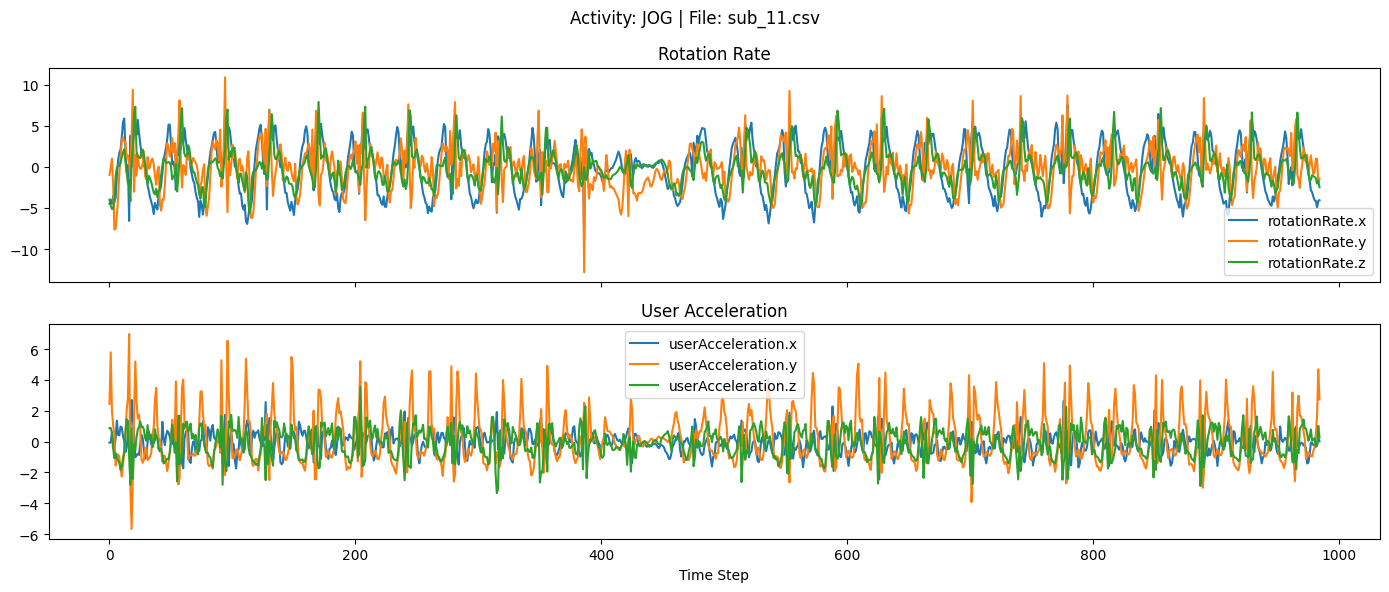

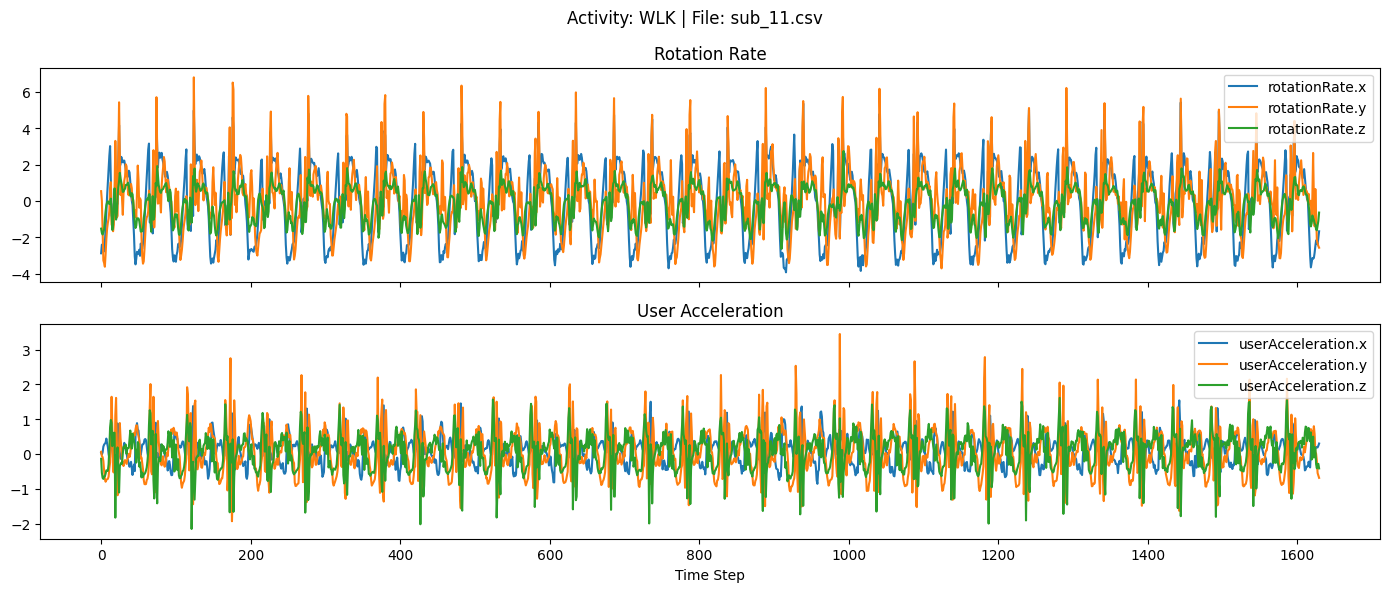

In [30]:
dataset = load_kaggle_malekzadeh_dataset("../data/kaggle-malekzadeh")

# Track which activity labels we've already seen
seen_labels = set()

# Loop through the dataset
for df, label, path in dataset:
    if label in seen_labels:
        continue  # skip duplicates
    
    seen_labels.add(label)

    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
    fig.suptitle(f"Activity: {label.upper()} | File: {os.path.basename(path)}")

    # Plot rotationRate
    axs[0].set_title("Rotation Rate")
    for axis in ['rotationRate.x', 'rotationRate.y', 'rotationRate.z']:
        if axis in df.columns:
            axs[0].plot(df.index, df[axis], label=axis)
    axs[0].legend()

    # Plot userAcceleration
    axs[1].set_title("User Acceleration")
    for axis in ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']:
        if axis in df.columns:
            axs[1].plot(df.index, df[axis], label=axis)
    axs[1].legend()

    axs[1].set_xlabel("Time Step")
    plt.tight_layout()
    plt.show()

    # Stop when we've shown all types (edit this set if more labels exist)
    if seen_labels >= {'jog', 'wlk', 'sit', 'std'}:
        break
